In [1]:
import sys
sys.path.append('../../')

In [ ]:
pip install

In [2]:
import os
import time
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [3]:
from bilevel_optimisation.fields_of_experts.FieldsOfExperts import FieldsOfExperts
from bilevel_optimisation.measurement_model.MeasurementModel import MeasurementModel
from bilevel_optimisation.dataset.ImageDataset import TestImageDataset
from bilevel_optimisation.utils.DatasetUtils import collate_function
from bilevel_optimisation.optimiser import NAGOptimiser
from bilevel_optimisation.factories.BuildFactory import build_optimiser_factory, build_prox_map_factory
from bilevel_optimisation.optimiser.StoppingCriterion import EarlyStopping
from bilevel_optimisation.potential import StudentT
from bilevel_optimisation.data.ParamSpec import ParamSpec
from bilevel_optimisation.data.OptimiserSpec import OptimiserSpec
from bilevel_optimisation.energy import OptimisationEnergy
from bilevel_optimisation.evaluation.Evaluation import compute_psnr

### Setup regulariser (load filter and filter weights from file)

In [8]:
model_data_dir = '../../data/pretrained_models'
filters_file = 'foe_filters_7x7_chen-ranftl-pock_2014.pt'
filter_weights_file = 'foe_filter-weights_7x7_thaler_2025.pt'

filters = 255 * torch.load(os.path.join(model_data_dir, filters_file))
filters_spec = ParamSpec(value=filters, trainable=False, parameters={'padding_mode': 'reflect'})

filter_weights = torch.load(os.path.join(model_data_dir, filter_weights_file))
filter_weights_spec = ParamSpec(value=filter_weights, trainable=False)

potential = StudentT()

regulariser = FieldsOfExperts(potential, filters_spec, filter_weights_spec)

### Setup image dataset

In [9]:
dtype = torch.float64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
test_data_root_dir = '../../data/test_images'

test_image_dataset = TestImageDataset(root_path=test_data_root_dir, dtype=dtype)
test_loader = DataLoader(test_image_dataset, batch_size=len(test_image_dataset), shuffle=False,
                         collate_fn=lambda x: collate_function(x, crop_size=-1))

### Setup measurement model

In [11]:
test_batch = list(test_loader)[0]
test_batch_ = test_batch.to(device=device, dtype=dtype)

noise_level = 0.1
forward_operator = torch.nn.Identity()

measurement_model = MeasurementModel(test_batch, forward_operator, noise_level)

### Setup inner energy

In [12]:
lam = 0.005

prox_map = lambda x, y, tau: (tau * y + x) / (1 + tau)
prox_map_factory = build_prox_map_factory(prox_map)
optimiser_spec = OptimiserSpec(optimiser_class=NAGOptimiser, optimiser_params={'lip_const_default': 1024},
                               stopping_class=EarlyStopping, stopping_params={'max_num_iterations': 1000, 'rel_tol': 1e-5}, 
                               prox_map_factory=prox_map_factory)
optimiser_factory = build_optimiser_factory(optimiser_spec)

energy = OptimisationEnergy(measurement_model, regulariser, lam, optimiser_factory)
energy.to(device=device, dtype=dtype)

OptimisationEnergy(
  (measurement_model): MeasurementModel(
    (_operator): Identity()
  )
  (regulariser): FieldsOfExperts(
    (_potential): StudentT()
  )
)

In [13]:
t0 = time.time()
test_batch_denoised = energy.argmin(energy.measurement_model.obs_noisy)
t1 = time.time()

print('denoising stats:')
print(' > elapsed time [s] = {:.5f}'.format(t1 - t0))

denoising stats:
 > elapsed time [s] = 62.44400


 > psnr [dB] = 29.40296


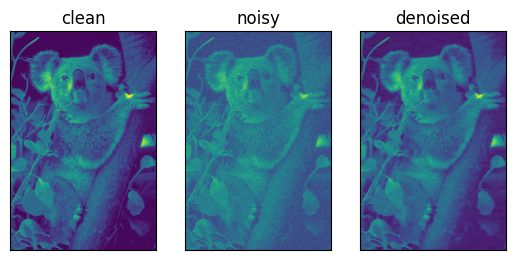

 > psnr [dB] = 29.20122


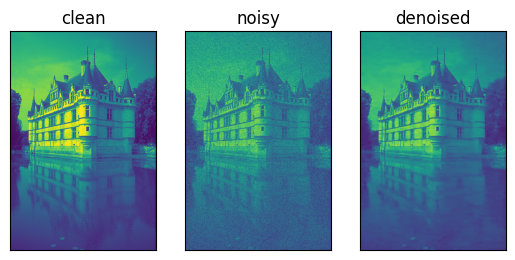

In [14]:
u_clean_splits = torch.split(test_batch_, split_size_or_sections=1, dim=0)
u_noisy_splits = torch.split(energy.measurement_model.obs_noisy, split_size_or_sections=1, dim=0)
u_denoised_splits = torch.split(test_batch_denoised, split_size_or_sections=1, dim=0)
for idx, (item_clean, item_noisy, item_denoised) in (
        enumerate(zip(u_clean_splits, u_noisy_splits, u_denoised_splits))):
    psnr = compute_psnr(item_clean, item_denoised)
    print(' > psnr [dB] = {:.5f}'.format(psnr.detach().cpu().item()))

    fig = plt.figure()
    ax_clean = fig.add_subplot(1, 3, 1)
    ax_clean.imshow(item_clean.squeeze().detach().cpu().numpy())
    ax_clean.set_title('clean')
    ax_clean.xaxis.set_visible(False)
    ax_clean.yaxis.set_visible(False)

    ax_noisy = fig.add_subplot(1, 3, 2)
    ax_noisy.imshow(item_noisy.squeeze().detach().cpu().numpy())
    ax_noisy.set_title('noisy')
    ax_noisy.xaxis.set_visible(False)
    ax_noisy.yaxis.set_visible(False)

    ax_denoised = fig.add_subplot(1, 3, 3)
    ax_denoised.imshow(item_denoised.squeeze().detach().cpu().numpy())
    ax_denoised.set_title('denoised')
    ax_denoised.xaxis.set_visible(False)
    ax_denoised.yaxis.set_visible(False)
    plt.show()
